In [1]:
import warnings
import shap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

In [3]:
%run TII_train_net_from_description.py

[82740, 131072, -7]
Epoch 1/100
14/14 [==============================] - 10s 67ms/step - loss: 1.1404 - val_loss: 0.6999 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 0s 24ms/step - loss: 0.6807 - val_loss: 0.6112 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 0s 24ms/step - loss: 0.5997 - val_loss: 0.5839 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 0s 22ms/step - loss: 0.5588 - val_loss: 0.5532 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 0s 24ms/step - loss: 0.5316 - val_loss: 0.5242 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 22ms/step - loss: 0.4980 - val_loss: 0.4938 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 0s 22ms/step - loss: 0.4638 - val_loss: 0.4633 - lr: 0.0010
Epoch 8/100
14/14 [==============================] - 0s 22ms/step - loss: 0.4334 - val_loss: 0.4274 - lr: 0.0010
Epoch 9/100
14/14 [==============================] - 0s 23ms/step - loss: 0

In [4]:
# We will now directly use the original 4D data
consistent_samples = []

In [5]:
# Loop through each index in fold_test_ind and select the first time step to match the expected shape
for idx in fold_test_ind[:100]:  # Limiting to the first 100 samples
    sample = Xd[idx]
    
    try:
        # Select the first time step (shape should be (64, 64, 8))
        sample_reshaped = np.array(sample[0])  # Taking the first time step
        
        # Append the reshaped sample to the list
        consistent_samples.append(sample_reshaped)
        
        print(f"Sample {idx} reshaped shape: {sample_reshaped.shape}")
        
    except Exception as e:
        print(f"Error at sample {idx}: {e}")


Sample [   8   12   15 ... 5643 5644 5646] reshaped shape: (64, 64, 8)
Sample [  14   19   24 ... 5648 5649 5650] reshaped shape: (64, 64, 8)
Sample [   0    6    7 ... 5642 5645 5647] reshaped shape: (64, 64, 8)
Sample [   1    2   10 ... 5632 5635 5637] reshaped shape: (64, 64, 8)
Sample [   3    4    5 ... 5638 5640 5641] reshaped shape: (64, 64, 8)


## Shap Values Visualization - Bar Chart - Aggregated - No Direction

SHAP values shape: (5, 64, 64, 8, 2)
Data shape: (5, 64, 64, 8)
Aggregated SHAP values shape: (5, 8, 2)
Aggregated Data shape: (5, 8)


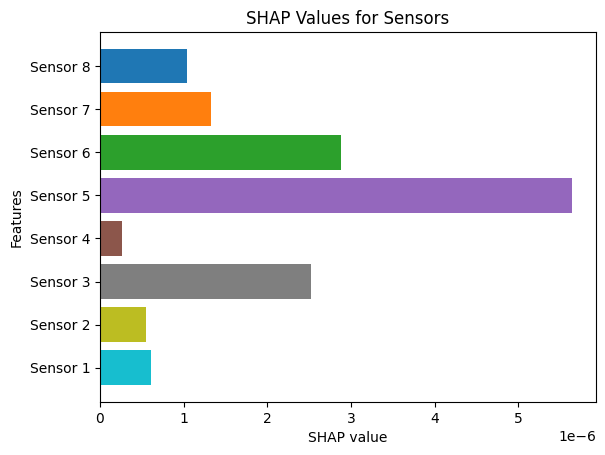

In [29]:
# Now use SHAP with the 4D consistent data
if len(consistent_samples) > 0:
    consistent_data = np.array(consistent_samples)  # Keep the data in 4D
    
    # Initialize SHAP explainer with the original 4D training data
    train_data_4d = np.array([Xd[idx][0] for idx in fold_train_ind[:100]])  # Taking the first time step
    explainer = shap.DeepExplainer(model, train_data_4d)  # Keep 4D data
    
    # Compute SHAP values on the 4D consistent test data
    shap_values = explainer.shap_values(consistent_data)

    # Inspect the shape of SHAP values and data
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Data shape: {consistent_data.shape}")

    # If SHAP values are a list, select the first output (for binary classification)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Aggregate SHAP values across the (64, 64) grid for each of the 8 sensors
    shap_values_per_sensor = np.mean(shap_values, axis=(1, 2))  # Mean across (64, 64) grid
    consistent_data_per_sensor = np.mean(consistent_data, axis=(1, 2))  # Mean across (64, 64) grid

    # Check the shapes after aggregation (should be (samples, 8 sensors))
    print(f"Aggregated SHAP values shape: {shap_values_per_sensor.shape}")
    print(f"Aggregated Data shape: {consistent_data_per_sensor.shape}")

    # Ensure we have 8 sensors in the output (if not, raise an error)
    if shap_values_per_sensor.shape[1] != 8:
        raise ValueError(f"Expected 8 sensors but got {shap_values_per_sensor.shape[1]}.")

    # Select the first output from SHAP values (for binary classification)
    shap_values_first_output = shap_values_per_sensor[:, :, 0]  # Select first output (shape: (samples, 8))

    # Plot sensors in order
    ordered_indices = np.argsort([8, 7, 6, 5, 4, 3, 2, 1])  
    shap_values_ordered = np.mean(np.abs(shap_values_first_output), axis=0)[ordered_indices]

    # Plot the SHAP values with distinct colors
    feature_names = [f'Sensor {i}' for i in range(8, 0, -1)]
    colormap = plt.get_cmap('tab10')  # Get the colormap
    colors = colormap(np.linspace(0, 1, len(feature_names)))  # Generate distinct colors for each bar

    plt.barh(feature_names, shap_values_ordered, color=colors)
    plt.ylabel("Features")
    plt.xlabel("SHAP value")
    plt.title("SHAP Values for Sensors")
    plt.gca().invert_yaxis()  # Invert y-axis so Sensor 8 is at the bottom
    plt.show()

else:
    print("No consistent samples found for SHAP analysis.")

## Shap Values Visualization - Bar Chart - Per Sample

SHAP values shape: (5, 64, 64, 8, 2)
Data shape: (5, 64, 64, 8)


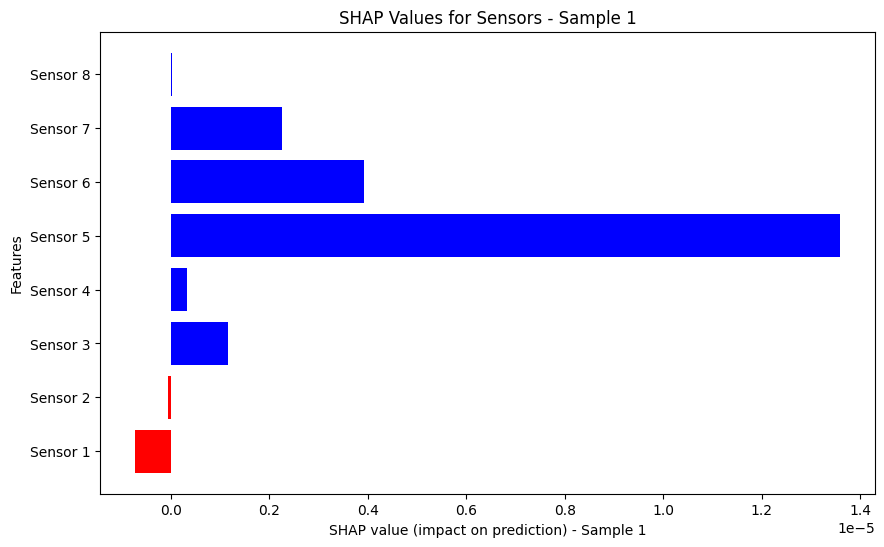

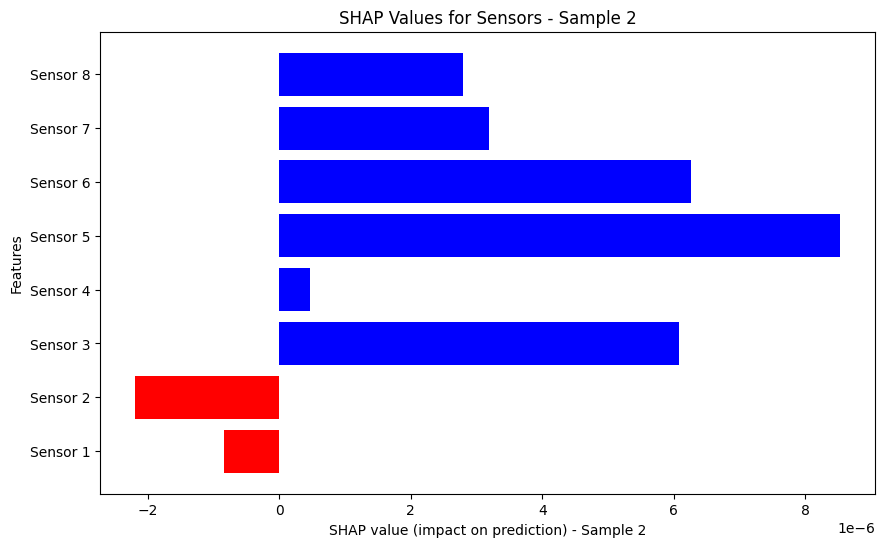

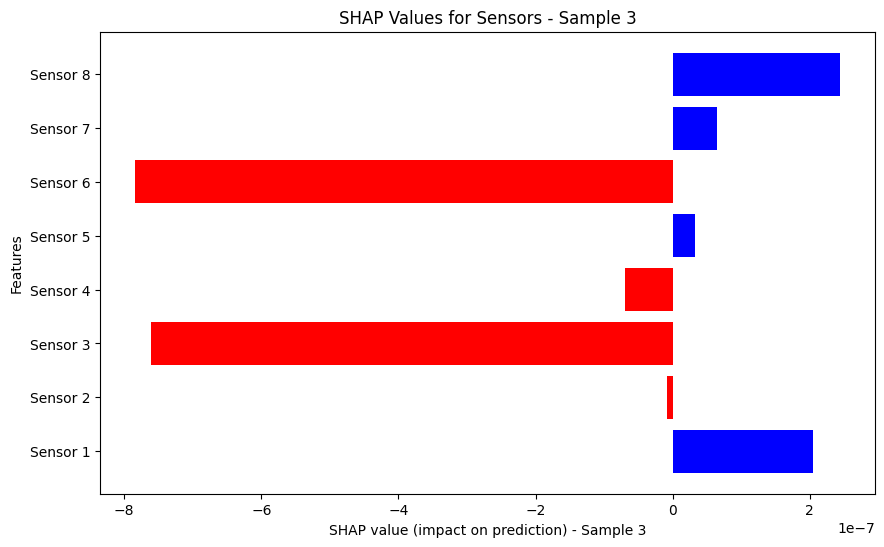

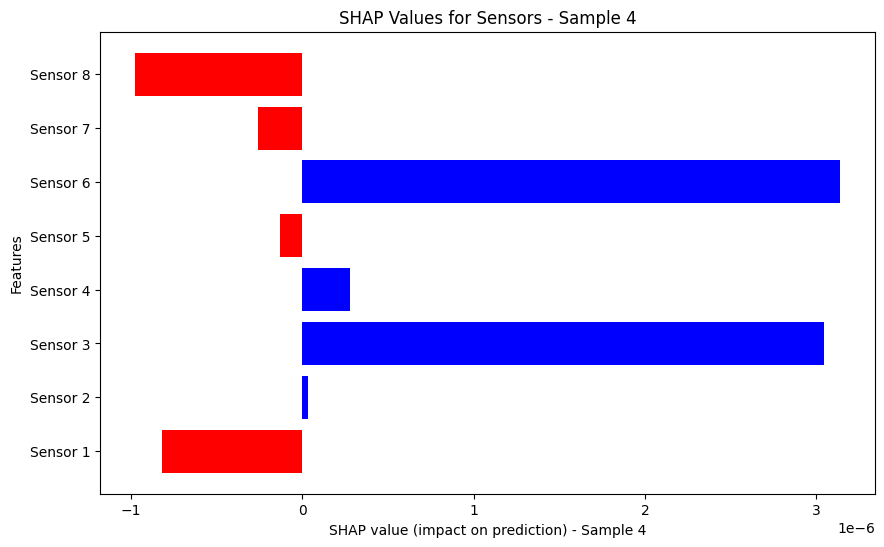

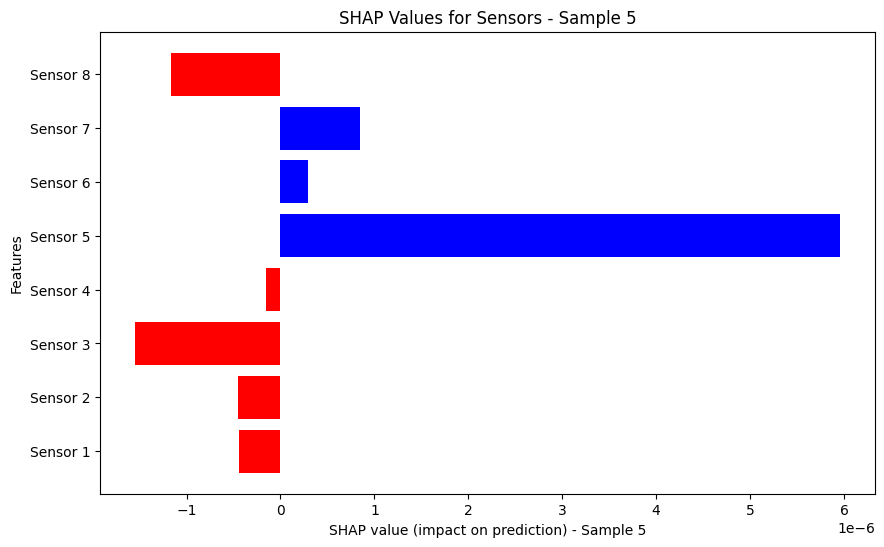

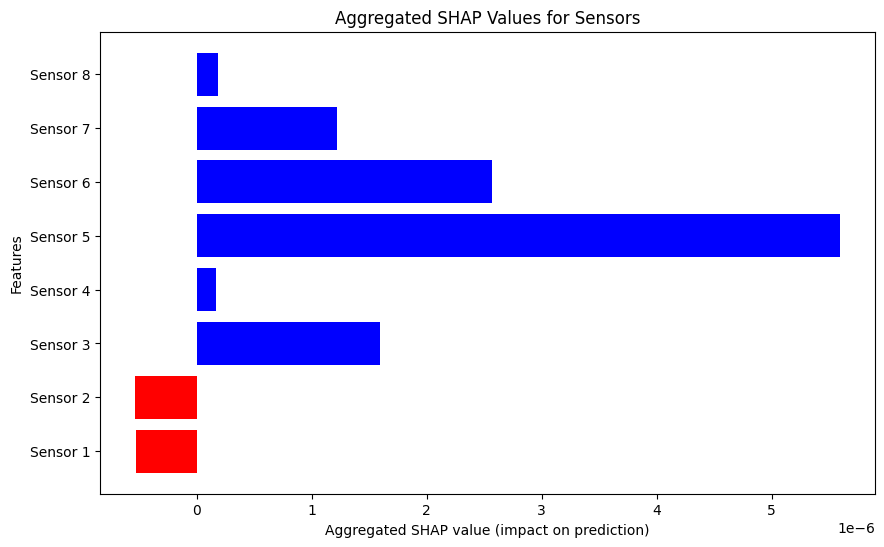

In [28]:
# Now use SHAP with the 4D consistent data
if len(consistent_samples) > 0:
    consistent_data = np.array(consistent_samples)  # Keep the data in 4D
    
    # Initialize SHAP explainer with the original 4D training data
    train_data_4d = np.array([Xd[idx][0] for idx in fold_train_ind[:100]])  # Taking the first time step
    explainer = shap.DeepExplainer(model, train_data_4d)  # Keep 4D data
    
    # Compute SHAP values on the 4D consistent test data
    shap_values = explainer.shap_values(consistent_data)

    # Inspect the shape of SHAP values and data
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Data shape: {consistent_data.shape}")

    # If SHAP values are a list, select the first output (for binary classification)
    if isinstance(shap_values, list):
       shap_values_first_output = shap_values[0]

    # Aggregated SHAP values per sensor (optional for comparison)
    shap_values_ordered = np.mean(shap_values_first_output, axis=0)  # Mean across samples if needed

    # Plot SHAP values for each sample in a bar chart
    for i in range(5):  # Loop over the 5 samples
       plt.figure(figsize=(10, 6))
       plt.barh([f'Sensor {j}' for j in range(1, 9)], shap_values_first_output[i], color=['red' if val < 0 else 'blue' for val in shap_values_first_output[i]])
       plt.ylabel("Features")
       plt.xlabel(f"SHAP value (impact on prediction) - Sample {i+1}")
       plt.title(f"SHAP Values for Sensors - Sample {i+1}")
       plt.show()

    # Optionally, you can also display the aggregated SHAP values (as you've been doing previously)
    plt.figure(figsize=(10, 6))
    plt.barh([f'Sensor {i}' for i in range(1, 9)], shap_values_ordered, color=['red' if val < 0 else 'blue' for val in shap_values_ordered])
    plt.ylabel("Features")
    plt.xlabel("Aggregated SHAP value (impact on prediction)")
    plt.title("Aggregated SHAP Values for Sensors")
    plt.show()

## Shap Values Visualization - Bar Chart - Aggregated - Has Direction

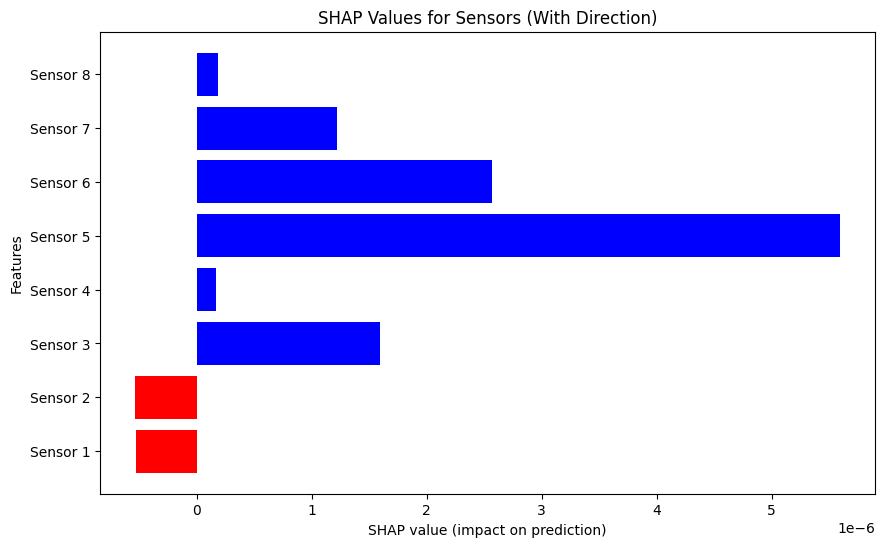

In [26]:
# Aggregated SHAP values for each sensor (already calculated)
shap_values_ordered = np.mean(shap_values_first_output, axis=0)  # Mean across samples if needed

# Define sensor names
feature_names = [f'Sensor {i}' for i in range(1, 9)]

# Plot the bar chart with both positive and negative SHAP values
plt.figure(figsize=(10, 6))

# Bar chart showing both positive and negative SHAP values
plt.barh(feature_names, shap_values_ordered, color=['red' if val < 0 else 'blue' for val in shap_values_ordered])

plt.ylabel("Features")
plt.xlabel("SHAP value (impact on prediction)")
plt.title("SHAP Values for Sensors (With Direction)")
plt.show()

## Shap Values Visualization - (Heatmap, Scatter Plot, Line Plot)

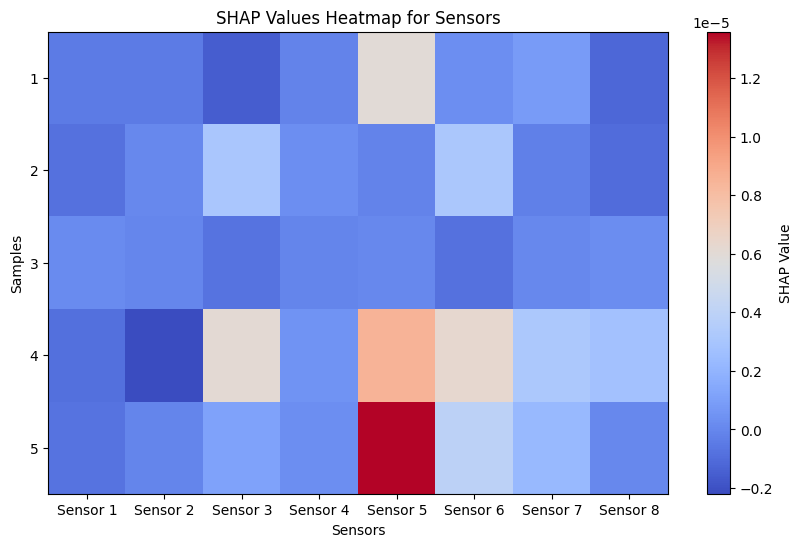

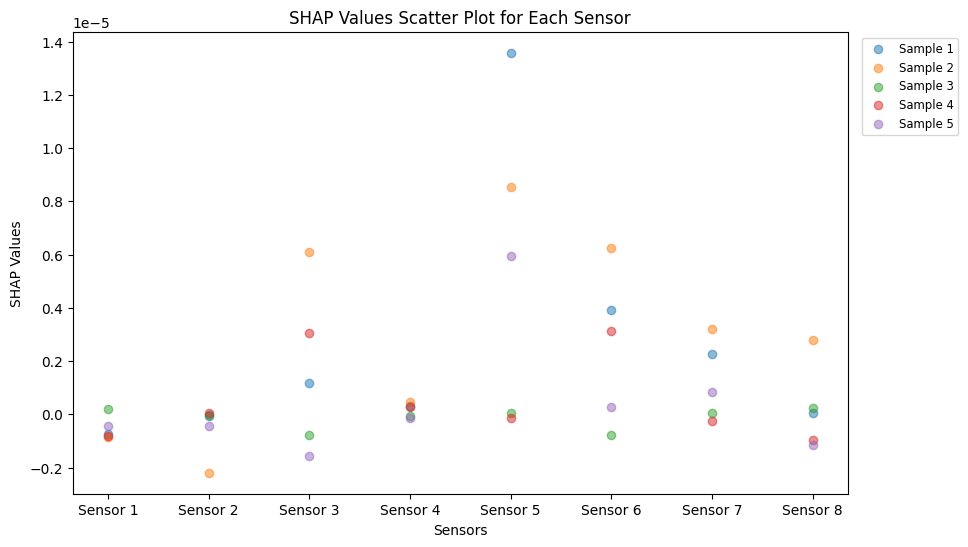

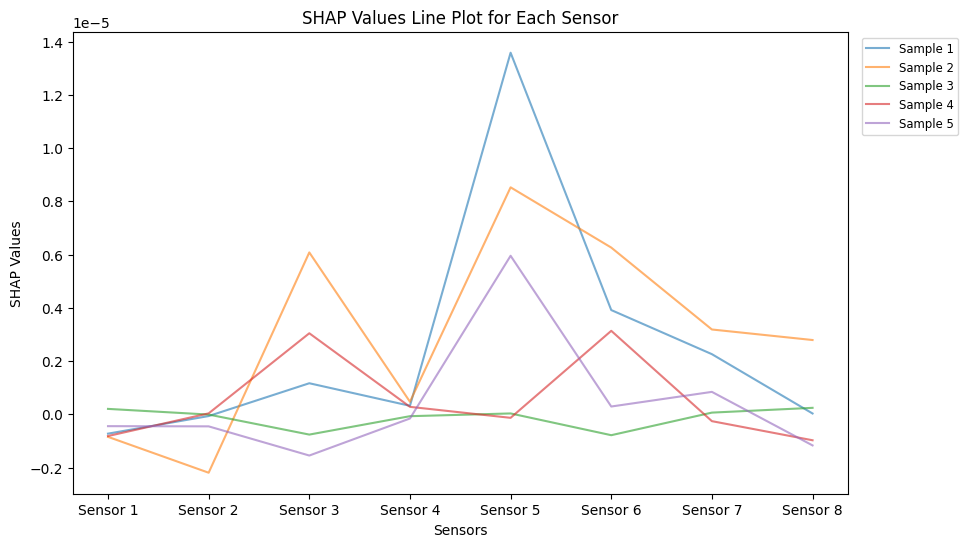

In [13]:
    # New visualization: Heatmap of SHAP values per sensor using matplotlib
    plt.figure(figsize=(10, 6))

    # Create a heatmap using the SHAP values for each sample and sensor
    plt.imshow(shap_values_first_output, aspect='auto', cmap='coolwarm')
    
    plt.colorbar(label="SHAP Value")
    plt.xticks(ticks=np.arange(8), labels=[f'Sensor {i}' for i in range(1, 9)])
    
    # Set y-ticks to start from 1 at the bottom and increase upwards
    plt.yticks(ticks=np.arange(shap_values_first_output.shape[0]), labels=np.arange(1, shap_values_first_output.shape[0] + 1)[::-1])

    # Invert the y-axis so that 1 is at the bottom and the highest sample number is at the top
    plt.gca().invert_yaxis()

    plt.xlabel("Sensors")
    plt.ylabel("Samples")
    plt.title("SHAP Values Heatmap for Sensors")
    plt.show()

    # New visualization: Scatter plot of SHAP values per sensor
    plt.figure(figsize=(10, 6))

    # Loop through each sample and plot the SHAP values for the 8 sensors
    for i in range(shap_values_first_output.shape[0]):
        plt.scatter(np.arange(1, 9), shap_values_first_output[i, :], label=f'Sample {i+1}', alpha=0.5)

    plt.xlabel("Sensors")
    plt.ylabel("SHAP Values")
    plt.title("SHAP Values Scatter Plot for Each Sensor")
    plt.xticks(ticks=np.arange(1, 9), labels=[f'Sensor {i}' for i in range(1, 9)])

    # Optionally add a legend (can be omitted for larger datasets)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')

    plt.show()

    # New simple visualization: Line plot of SHAP values per sensor
    plt.figure(figsize=(10, 6))

    # Plot SHAP values for each sample as a line
    for i in range(shap_values_first_output.shape[0]):
        plt.plot(np.arange(1, 9), shap_values_first_output[i, :], label=f'Sample {i+1}', alpha=0.6)

    plt.xlabel("Sensors")
    plt.ylabel("SHAP Values")
    plt.title("SHAP Values Line Plot for Each Sensor")
    plt.xticks(ticks=np.arange(1, 9), labels=[f'Sensor {i}' for i in range(1, 9)])

    # Optionally add a legend (can be omitted for larger datasets)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')

    plt.show()

## Shap Specific Visualizations: Shap Summary Plot & Shap Dependence Plot

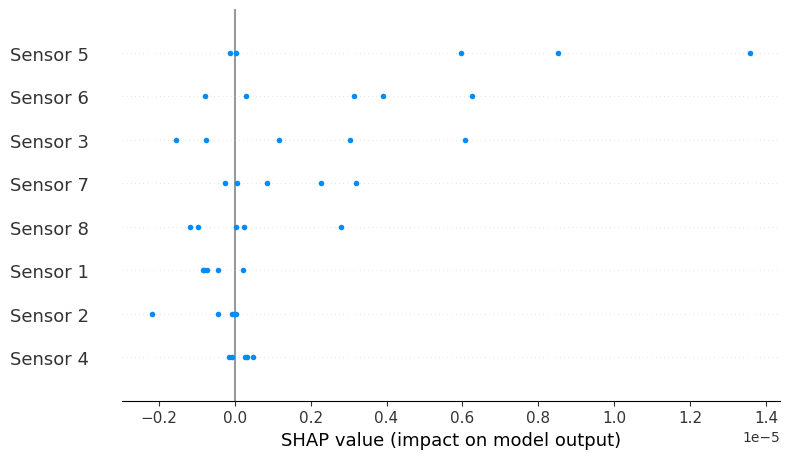

<Figure size 1000x600 with 0 Axes>

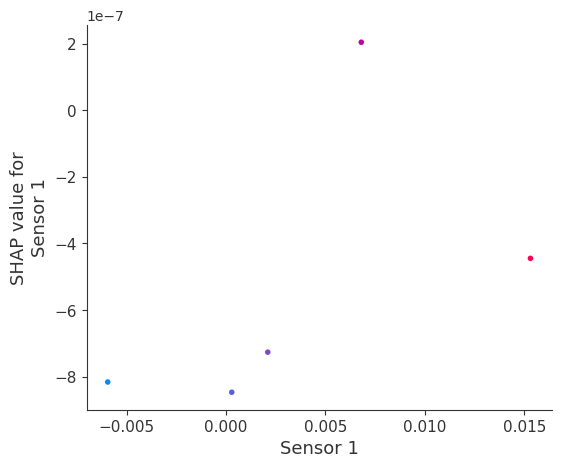

SHAP values shape for sample 0: (8,)
Feature data shape for sample 0: (8,)


In [20]:
    # SHAP Summary Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_first_output, feature_names=[f'Sensor {i}' for i in range(1, 9)])
    plt.show()

    # SHAP Dependence Plot (Choose one sensor, for example, sensor 1)
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(0, shap_values_first_output, consistent_data_per_sensor, feature_names=[f'Sensor {i}' for i in range(1, 9)])
    plt.show()

    # Select the sample index to visualize
    sample_index = 0  # You can choose a different sample index if desired

    # Select the SHAP values and feature data for this sample
    shap_values_for_sample = shap_values_first_output[sample_index]
    consistent_data_for_sample = consistent_data_per_sensor[sample_index]

    # Ensure both SHAP values and feature data are 1D arrays (flatten if necessary)
    if len(shap_values_for_sample.shape) > 1:
        shap_values_for_sample = shap_values_for_sample.flatten()
    if len(consistent_data_for_sample.shape) > 1:
        consistent_data_for_sample = consistent_data_for_sample.flatten()

    # Check the shape of the arrays to ensure they are 1D
    print(f"SHAP values shape for sample {sample_index}: {shap_values_for_sample.shape}")
    print(f"Feature data shape for sample {sample_index}: {consistent_data_for_sample.shape}")

    # Ensure the arrays are the same length (one SHAP value per feature)
    if shap_values_for_sample.shape[0] != consistent_data_for_sample.shape[0]:
        raise ValueError("SHAP values and feature data must have the same length!")

## Shap Specific Visualizations : Shap Force Plot

Selected expected value: 0.6073684096336365
SHAP values shape: (8,)
Feature data shape: (8,)


<Figure size 1000x600 with 0 Axes>

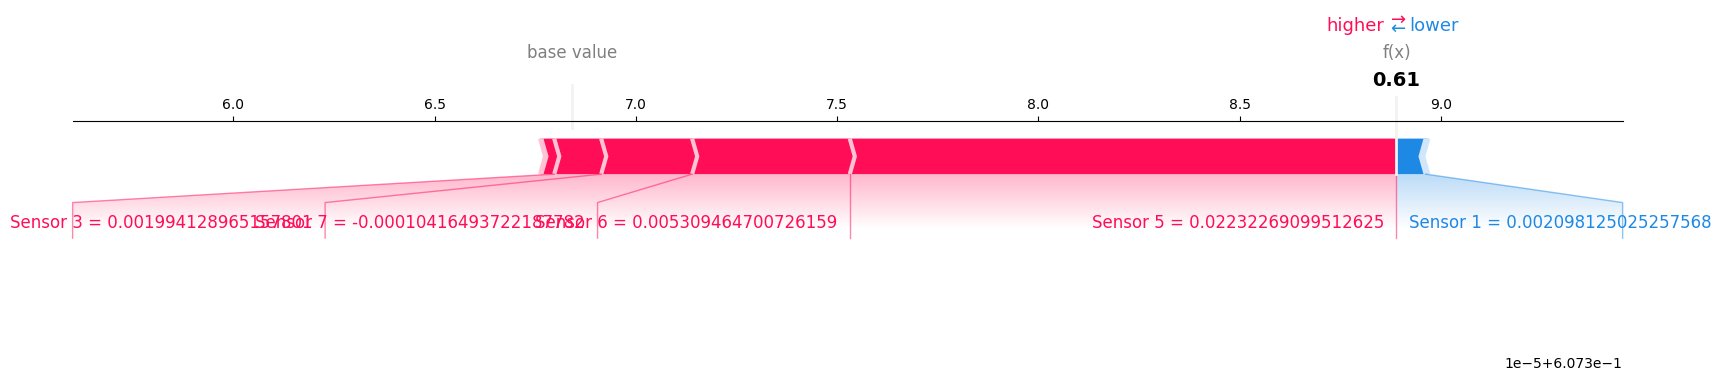

In [25]:
# Ensure expected_value is a scalar (manually set to the first class value or as needed)
expected_value = float(explainer.expected_value[1])  # Choose class 1, or use explainer.expected_value[0] for class 0

# Print the selected expected value for debugging
print(f"Selected expected value: {expected_value}")

# Ensure both SHAP values and feature data are flattened and are 1D arrays
shap_values_for_sample = shap_values_for_sample.flatten()
consistent_data_for_sample = consistent_data_for_sample.flatten()

# Check the shapes of SHAP values and feature data
print(f"SHAP values shape: {shap_values_for_sample.shape}")
print(f"Feature data shape: {consistent_data_for_sample.shape}")

# Plot the force plot using matplotlib
plt.figure(figsize=(10, 6))
shap.force_plot(
    expected_value,  # This should be a scalar
    shap_values_for_sample,  # 1D array of SHAP values
    consistent_data_for_sample,  # 1D array of feature values
    feature_names=[f'Sensor {i}' for i in range(1, 9)],  # List of feature names
    matplotlib=True  # Render as a static image
)
plt.show()
